In [1]:
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

# 1. Adatok betöltése és előkészítése

In [2]:
movies_columns = ['movie_id', 'title', 'genres']
ratings_columns = ['user', 'movie', 'rating', 'timestamp'] # UserID::MovieID::Rating::Timestamp

df_movies = pd.read_table('./data/movies.dat', sep='::', header=None, 
                          names=movies_columns, encoding="ISO-8859-1", engine="python")
df_ratings = pd.read_table('./data/ratings.dat', sep='::', header=None, 
                           names=ratings_columns, encoding="ISO-8859-1", engine="python")

df_ratings.user -= 1
df_ratings.movie -= 1
df_movies.movie_id -= 1

In [3]:
df_ratings.head()

,user,movie,rating,timestamp
0,0,1192,5,978300760
1,0,660,3,978302109
2,0,913,3,978301968
3,0,3407,4,978300275
4,0,2354,5,978824291


In [4]:
df_movies.head()

,movie_id,title,genres
0,0,Toy Story (1995),Animation|Children's|Comedy
1,1,Jumanji (1995),Adventure|Children's|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Waiting to Exhale (1995),Comedy|Drama
4,4,Father of the Bride Part II (1995),Comedy


In [5]:
# Minden filmhez kiválasztjuk a kategóriák közül az elsőt, ez egy későbbi részhez szükséges
df_movies["genre1"] = df_movies.genres.str.split("|").apply(lambda x: x[0])
df_movies.head()

,movie_id,title,genres,genre1
0,0,Toy Story (1995),Animation|Children's|Comedy,Animation
1,1,Jumanji (1995),Adventure|Children's|Fantasy,Adventure
2,2,Grumpier Old Men (1995),Comedy|Romance,Comedy
3,3,Waiting to Exhale (1995),Comedy|Drama,Comedy
4,4,Father of the Bride Part II (1995),Comedy,Comedy


In [6]:
# segéd függvény, amivel cím alapján kereshetünk filmet
def search_movies(title, limit=10):
    return df_movies[df_movies.title.str.contains(title, flags=re.IGNORECASE)].iloc[:limit]

In [7]:
search_movies("lion")

,movie_id,title,genres,genre1
360,363,"Lion King, The (1994)",Animation|Children's|Musical,Animation
1980,2048,"Happiest Millionaire, The (1967)",Comedy|Musical,Comedy


In [8]:
n_user, n_item = df_ratings.user.max(), df_ratings.movie.max()
n_user, n_item

(6039, 3951)

# 2. Interakciós mátrix építése és dekompozíció

In [9]:
ratings = df_ratings.rating.values / df_ratings.rating.max()
rows = df_ratings.user.values
cols = df_ratings.movie.values
R = coo_matrix((ratings, (rows, cols)), shape=(n_user+1, n_item+1))

In [10]:
N = 12
model = NMF(n_components=N, max_iter=1000, init='nndsvda').fit(R)
#model = TruncatedSVD(n_components=N, n_iter=200).fit(R)

In [11]:
# Kinyerjük az U és V mátrixokat
U, V = model.transform(R), model.components_.T
U.shape, V.shape

((6040, 12), (3952, 12))

# 3. Tanult beágyazások vizsgálata

/home/ricsi/venvs/base/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/ricsi/venvs/base/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

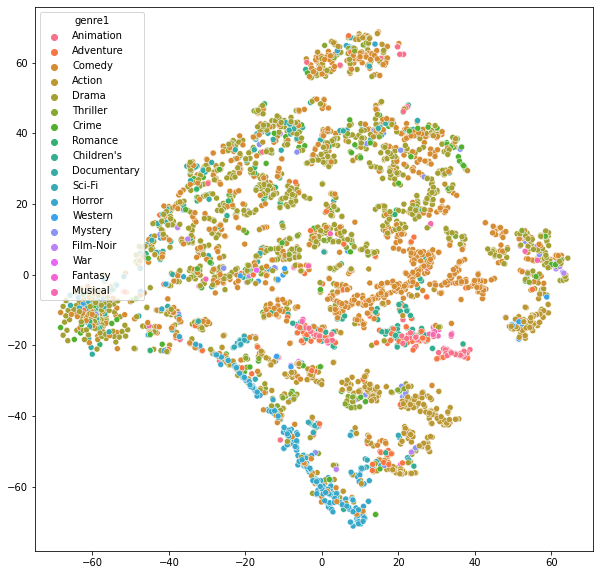

In [12]:
z = TSNE(n_components=2, init="pca", learning_rate='auto').fit_transform(V)
z = z[df_movies.movie_id.values]

plt.figure(figsize=(10,10))
sns.scatterplot(z[:, 0], z[:, 1], hue=df_movies.genre1)

# 4. Ajánló rendszer építése a tanult beágyazások alapján

In [13]:
K = 10
METRIC = "cosine"

knn = NearestNeighbors(n_neighbors=K, metric=METRIC).fit(V)

def get_neighbors(movie):
    _, indices = knn.kneighbors(V[movie].reshape(1, N))
    return indices[0].tolist()

In [14]:
all_movies = df_movies.movie_id.unique()

def recommend_movies(movie):
    return [
                (neighbor, df_movies[df_movies.movie_id == neighbor].title.item())
                for neighbor in get_neighbors(movie) 
                if neighbor in all_movies
    ]

In [15]:
search_movies("star")

,movie_id,title,genres,genre1
122,123,"Star Maker, The (Uomo delle stelle, L') (1995)",Drama,Drama
129,130,Frankie Starlight (1995),Drama|Romance,Drama
195,196,"Stars Fell on Henrietta, The (1995)",Drama,Drama
257,259,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,Action
313,315,Stargate (1994),Action|Adventure|Sci-Fi,Action
325,328,Star Trek: Generations (1994),Action|Adventure|Sci-Fi,Action
790,799,Lone Star (1996),Drama|Mystery,Drama
1025,1037,Unhook the Stars (1996),Drama,Drama
1178,1195,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,Action
1192,1209,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,Action


In [16]:
# Kipróbáljuk a start wars 4.-hez mit ajánl
recommend_movies(259)

[(259, 'Star Wars: Episode IV - A New Hope (1977)'),
 (1195, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (1209, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (1239, 'Terminator, The (1984)'),
 (1197, 'Raiders of the Lost Ark (1981)'),
 (1199, 'Aliens (1986)'),
 (1213, 'Alien (1979)'),
 (1096, 'E.T. the Extra-Terrestrial (1982)'),
 (588, 'Terminator 2: Judgment Day (1991)'),
 (642, 'Peanuts - Die Bank zahlt alles (1996)')]